In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_conv_3_VGG_DO_025_DO(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=3, filters=64, strides=1, padding='same', 
                      activation='relu', input_shape=input_shape)) 
    model.add(Conv1D (kernel_size=3, filters=64, strides=1, padding='same', 
                  activation='relu')) 
#     model.add(BatchNormalization())
#     model.add(MaxPooling1D(pool_size=3, strides=3))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=3, filters=64*(2**int((i+1)/4)), strides=1, padding='same', 
                          activation='relu'))
        model.add(Conv1D (kernel_size=3, filters=64*(2**int((i+1)/4)), strides=1, padding='same', 
                          activation='relu'))         
#         model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(Dropout(0.25))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_conv_3_VGG_DO_025_DO(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         256       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16000, 64)         12352     
_________________________________________________________________
flatten (Flatten)            (None, 1024000)           0         
_________________________________________________________________
dropout (Dropout)            (None, 1024000)           0         
_________________________________________________________________
dense (Dense)                (None, 16)                16384016  
Total params: 16,396,624
Trainable params: 16,396,624
Non-trainable params: 0
_________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_30 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 5333, 64)          12352     
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 5333, 64)          12352     
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_72 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
conv1d_73 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_74 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_75 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_76 (Conv1D)           (None, 5333, 64)          12352     
_________________________________________________________________
conv1d_77 (Conv1D)           (None, 5333, 64)          12352     
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3349 - acc: 0.2689
Epoch 00001: val_loss improved from inf to 2.12713, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_025_DO_1_conv_checkpoint/001-2.1271.hdf5
36805/36805 [==============================] - 48s 1ms/sample - loss: 2.3349 - acc: 0.2689 - val_loss: 2.1271 - val_acc: 0.3520
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8612 - acc: 0.4422
Epoch 00002: val_loss improved from 2.12713 to 1.97683, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_025_DO_1_conv_checkpoint/002-1.9768.hdf5
36805/36805 [==============================] - 45s 1ms/sample - loss: 1.8613 - acc: 0.4421 - val_loss: 1.9768 - val_acc: 0.4142
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4826 - acc: 0.5670
Epoch 00003: val_loss improved from 1.97683 to 

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0240 - acc: 0.9983
Epoch 00029: val_loss did not improve from 1.96552
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.0240 - acc: 0.9983 - val_loss: 4.8919 - val_acc: 0.3447
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0303 - acc: 0.9968
Epoch 00030: val_loss did not improve from 1.96552
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.0303 - acc: 0.9968 - val_loss: 4.8891 - val_acc: 0.3480
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0271 - acc: 0.9975
Epoch 00031: val_loss did not improve from 1.96552
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.0271 - acc: 0.9975 - val_loss: 4.9931 - val_acc: 0.3520
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0242 - acc: 0.9980
Epoch 00032: val_loss did not improve from 1.96552
36805/36805 [===========

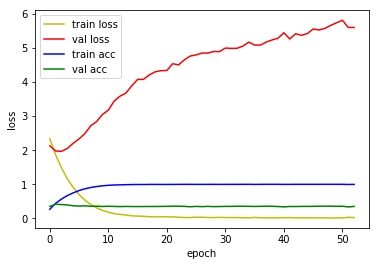

4815/4815 [==============================] - 2s 467us/sample - loss: 1.9995 - acc: 0.3880
Loss: 1.9994705936247685 Accuracy: 0.3879543

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2175 - acc: 0.3006
Epoch 00001: val_loss improved from inf to 1.90360, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_025_DO_2_conv_checkpoint/001-1.9036.hdf5
36805/36805 [==============================] - 74s 2ms/sample - loss: 2.2174 - acc: 0.3006 - val_loss: 1.9036 - val_acc: 0.4442
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7380 - acc: 0.4778
Epoch 00002: val_loss improved from 1.90360 to 1.71034, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_025_DO_2_conv_checkpoint/002-1.7103.hdf5
36805/36805 [==============================] - 72s 2ms/sample - loss: 1.7379 - acc: 0.4778 - val_loss: 1.7103 - val_acc: 0.4831
Epoch 3/500
36800/36805 [============================>.

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0336 - acc: 0.9953
Epoch 00029: val_loss did not improve from 1.66032
36805/36805 [==============================] - 71s 2ms/sample - loss: 0.0336 - acc: 0.9953 - val_loss: 4.7082 - val_acc: 0.4321
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0402 - acc: 0.9933
Epoch 00030: val_loss did not improve from 1.66032
36805/36805 [==============================] - 71s 2ms/sample - loss: 0.0402 - acc: 0.9933 - val_loss: 4.5648 - val_acc: 0.4533
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0245 - acc: 0.9974
Epoch 00031: val_loss did not improve from 1.66032
36805/36805 [==============================] - 71s 2ms/sample - loss: 0.0245 - acc: 0.9974 - val_loss: 4.6497 - val_acc: 0.4461
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0404 - acc: 0.9929
Epoch 00032: val_loss did not improve from 1.66032
36805/36805 [===========

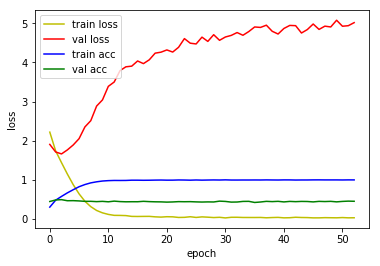

4815/4815 [==============================] - 4s 765us/sample - loss: 1.7299 - acc: 0.4675
Loss: 1.7299176984363132 Accuracy: 0.4674974

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2358 - acc: 0.2909
Epoch 00001: val_loss improved from inf to 1.82036, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_025_DO_3_conv_checkpoint/001-1.8204.hdf5
36805/36805 [==============================] - 84s 2ms/sample - loss: 2.2356 - acc: 0.2909 - val_loss: 1.8204 - val_acc: 0.4430
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5978 - acc: 0.5120
Epoch 00002: val_loss improved from 1.82036 to 1.51073, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_025_DO_3_conv_checkpoint/002-1.5107.hdf5
36805/36805 [==============================] - 81s 2ms/sample - loss: 1.5977 - acc: 0.5119 - val_loss: 1.5107 - val_acc: 0.5316
Epoch 3/500
36800/36805 [============================>.

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0577 - acc: 0.9865
Epoch 00029: val_loss did not improve from 1.42889
36805/36805 [==============================] - 81s 2ms/sample - loss: 0.0577 - acc: 0.9865 - val_loss: 3.4694 - val_acc: 0.5570
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0542 - acc: 0.9875
Epoch 00030: val_loss did not improve from 1.42889
36805/36805 [==============================] - 81s 2ms/sample - loss: 0.0542 - acc: 0.9874 - val_loss: 3.4116 - val_acc: 0.5532
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0499 - acc: 0.9886
Epoch 00031: val_loss did not improve from 1.42889
36805/36805 [==============================] - 81s 2ms/sample - loss: 0.0499 - acc: 0.9886 - val_loss: 3.4986 - val_acc: 0.5560
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0479 - acc: 0.9892
Epoch 00032: val_loss did not improve from 1.42889
36805/36805 [===========

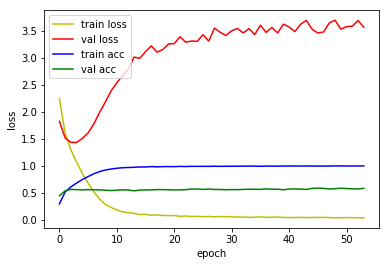

4815/4815 [==============================] - 4s 866us/sample - loss: 1.5099 - acc: 0.5327
Loss: 1.5099019443258441 Accuracy: 0.53271025

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1247 - acc: 0.3085
Epoch 00001: val_loss improved from inf to 1.54705, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_025_DO_4_conv_checkpoint/001-1.5470.hdf5
36805/36805 [==============================] - 88s 2ms/sample - loss: 2.1246 - acc: 0.3086 - val_loss: 1.5470 - val_acc: 0.4903
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4434 - acc: 0.5465
Epoch 00002: val_loss improved from 1.54705 to 1.30738, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_025_DO_4_conv_checkpoint/002-1.3074.hdf5
36805/36805 [==============================] - 85s 2ms/sample - loss: 1.4434 - acc: 0.5465 - val_loss: 1.3074 - val_acc: 0.5900
Epoch 3/500
36800/36805 [============================>

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0644 - acc: 0.9824
Epoch 00028: val_loss did not improve from 1.08842
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.0644 - acc: 0.9824 - val_loss: 1.9857 - val_acc: 0.6897
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0671 - acc: 0.9819
Epoch 00029: val_loss did not improve from 1.08842
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.0671 - acc: 0.9819 - val_loss: 2.0804 - val_acc: 0.6976
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0651 - acc: 0.9823
Epoch 00030: val_loss did not improve from 1.08842
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.0651 - acc: 0.9823 - val_loss: 2.0462 - val_acc: 0.6923
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0648 - acc: 0.9821
Epoch 00031: val_loss did not improve from 1.08842
36805/36805 [===========

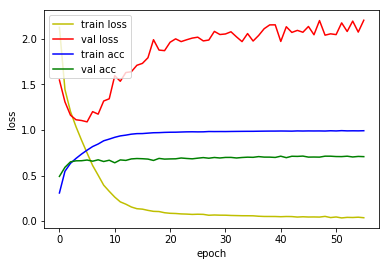

4815/4815 [==============================] - 4s 910us/sample - loss: 1.1628 - acc: 0.6463
Loss: 1.1627594412672928 Accuracy: 0.6463136

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0701 - acc: 0.3263
Epoch 00001: val_loss improved from inf to 1.49050, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_025_DO_5_conv_checkpoint/001-1.4905.hdf5
36805/36805 [==============================] - 93s 3ms/sample - loss: 2.0700 - acc: 0.3263 - val_loss: 1.4905 - val_acc: 0.5344
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3916 - acc: 0.5602
Epoch 00002: val_loss improved from 1.49050 to 1.21619, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_025_DO_5_conv_checkpoint/002-1.2162.hdf5
36805/36805 [==============================] - 88s 2ms/sample - loss: 1.3915 - acc: 0.5601 - val_loss: 1.2162 - val_acc: 0.6189
Epoch 3/500
36800/36805 [============================>.

36800/36805 [============================>.] - ETA: 0s - loss: 0.0738 - acc: 0.9782
Epoch 00027: val_loss did not improve from 0.78125
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0738 - acc: 0.9782 - val_loss: 1.2294 - val_acc: 0.7862
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0675 - acc: 0.9807
Epoch 00028: val_loss did not improve from 0.78125
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0675 - acc: 0.9807 - val_loss: 1.3080 - val_acc: 0.7750
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0679 - acc: 0.9805
Epoch 00029: val_loss did not improve from 0.78125
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0679 - acc: 0.9805 - val_loss: 1.2694 - val_acc: 0.7848
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0660 - acc: 0.9809
Epoch 00030: val_loss did not improve from 0.78125
36805/36805 [========================

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0398 - acc: 0.9896
Epoch 00057: val_loss did not improve from 0.78125
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.0398 - acc: 0.9896 - val_loss: 1.4023 - val_acc: 0.7864

1D_CNN_custom_conv_3_VGG_DO_025_DO_5_conv Model


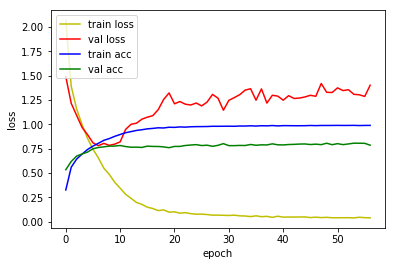

4815/4815 [==============================] - 5s 999us/sample - loss: 0.8740 - acc: 0.7358
Loss: 0.8739624065897299 Accuracy: 0.73582554

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2970 - acc: 0.2454
Epoch 00001: val_loss improved from inf to 1.68598, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_025_DO_6_conv_checkpoint/001-1.6860.hdf5
36805/36805 [==============================] - 95s 3ms/sample - loss: 2.2970 - acc: 0.2454 - val_loss: 1.6860 - val_acc: 0.4519
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4834 - acc: 0.5286
Epoch 00002: val_loss improved from 1.68598 to 1.24955, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_025_DO_6_conv_checkpoint/002-1.2496.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 1.4834 - acc: 0.5286 - val_loss: 1.2496 - val_acc: 0.6089
Epoch 3/500
36800/36805 [============================>

36800/36805 [============================>.] - ETA: 0s - loss: 0.1532 - acc: 0.9524
Epoch 00025: val_loss did not improve from 0.41756
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.1531 - acc: 0.9524 - val_loss: 0.4891 - val_acc: 0.8894
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1485 - acc: 0.9517
Epoch 00026: val_loss did not improve from 0.41756
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.1485 - acc: 0.9517 - val_loss: 0.4582 - val_acc: 0.8949
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1338 - acc: 0.9573
Epoch 00027: val_loss did not improve from 0.41756
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.1338 - acc: 0.9573 - val_loss: 0.4627 - val_acc: 0.8926
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1299 - acc: 0.9597
Epoch 00028: val_loss did not improve from 0.41756
36805/36805 [========================

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0507 - acc: 0.9852
Epoch 00055: val_loss did not improve from 0.41756
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0507 - acc: 0.9852 - val_loss: 0.5463 - val_acc: 0.9061
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0482 - acc: 0.9862
Epoch 00056: val_loss did not improve from 0.41756
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0487 - acc: 0.9861 - val_loss: 0.5914 - val_acc: 0.9026
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0566 - acc: 0.9837
Epoch 00057: val_loss did not improve from 0.41756
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0566 - acc: 0.9837 - val_loss: 0.5184 - val_acc: 0.9117
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0381 - acc: 0.9899
Epoch 00058: val_loss did not improve from 0.41756
36805/36805 [===========

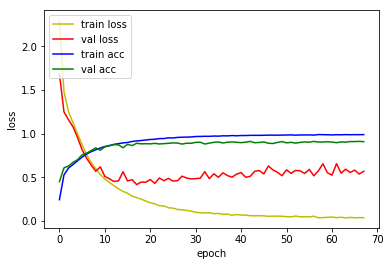

4815/4815 [==============================] - 5s 986us/sample - loss: 0.4982 - acc: 0.8606
Loss: 0.4982485526323566 Accuracy: 0.8606438

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4672 - acc: 0.1867
Epoch 00001: val_loss improved from inf to 1.80277, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_025_DO_7_conv_checkpoint/001-1.8028.hdf5
36805/36805 [==============================] - 100s 3ms/sample - loss: 2.4673 - acc: 0.1867 - val_loss: 1.8028 - val_acc: 0.4284
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5442 - acc: 0.4897
Epoch 00002: val_loss improved from 1.80277 to 1.33457, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_025_DO_7_conv_checkpoint/002-1.3346.hdf5
36805/36805 [==============================] - 90s 2ms/sample - loss: 1.5441 - acc: 0.4897 - val_loss: 1.3346 - val_acc: 0.5898
Epoch 3/500
36800/36805 [============================>

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1610 - acc: 0.9486
Epoch 00024: val_loss improved from 0.20289 to 0.19462, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_025_DO_7_conv_checkpoint/024-0.1946.hdf5
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.1609 - acc: 0.9486 - val_loss: 0.1946 - val_acc: 0.9420
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1525 - acc: 0.9514
Epoch 00025: val_loss improved from 0.19462 to 0.19310, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_025_DO_7_conv_checkpoint/025-0.1931.hdf5
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.1524 - acc: 0.9514 - val_loss: 0.1931 - val_acc: 0.9443
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1438 - acc: 0.9538
Epoch 00026: val_loss did not improve from 0.19310
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.1438 - acc: 0.

36800/36805 [============================>.] - ETA: 0s - loss: 0.0518 - acc: 0.9819
Epoch 00052: val_loss did not improve from 0.17938
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0518 - acc: 0.9819 - val_loss: 0.2418 - val_acc: 0.9509
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0535 - acc: 0.9815
Epoch 00053: val_loss did not improve from 0.17938
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0535 - acc: 0.9816 - val_loss: 0.2140 - val_acc: 0.9543
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0524 - acc: 0.9823
Epoch 00054: val_loss did not improve from 0.17938
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0524 - acc: 0.9823 - val_loss: 0.2436 - val_acc: 0.9485
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0469 - acc: 0.9843
Epoch 00055: val_loss did not improve from 0.17938
36805/36805 [========================

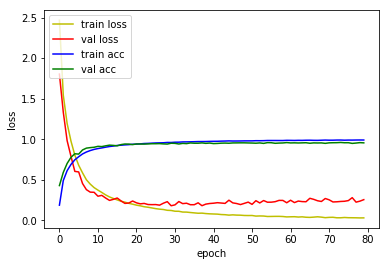

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.2296 - acc: 0.9375
Loss: 0.22960334255564127 Accuracy: 0.937487

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3246 - acc: 0.2274
Epoch 00001: val_loss improved from inf to 1.53173, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_025_DO_8_conv_checkpoint/001-1.5317.hdf5
36805/36805 [==============================] - 104s 3ms/sample - loss: 2.3247 - acc: 0.2274 - val_loss: 1.5317 - val_acc: 0.5064
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3680 - acc: 0.5470
Epoch 00002: val_loss improved from 1.53173 to 0.98108, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_025_DO_8_conv_checkpoint/002-0.9811.hdf5
36805/36805 [==============================] - 91s 2ms/sample - loss: 1.3679 - acc: 0.5470 - val_loss: 0.9811 - val_acc: 0.6858
Epoch 3/500
36800/36805 [============================>.]

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1294 - acc: 0.9572
Epoch 00024: val_loss did not improve from 0.14549
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.1294 - acc: 0.9572 - val_loss: 0.1627 - val_acc: 0.9518
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1278 - acc: 0.9582
Epoch 00025: val_loss did not improve from 0.14549
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.1278 - acc: 0.9582 - val_loss: 0.1905 - val_acc: 0.9441
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1214 - acc: 0.9602
Epoch 00026: val_loss did not improve from 0.14549
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.1214 - acc: 0.9602 - val_loss: 0.1596 - val_acc: 0.9564
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1116 - acc: 0.9616
Epoch 00027: val_loss improved from 0.14549 to 0.13968, saving model to mod

Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0373 - acc: 0.9870
Epoch 00053: val_loss did not improve from 0.13230
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0373 - acc: 0.9870 - val_loss: 0.1808 - val_acc: 0.9634
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0425 - acc: 0.9856
Epoch 00054: val_loss did not improve from 0.13230
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0425 - acc: 0.9856 - val_loss: 0.1680 - val_acc: 0.9623
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0386 - acc: 0.9867
Epoch 00055: val_loss did not improve from 0.13230
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0386 - acc: 0.9867 - val_loss: 0.1622 - val_acc: 0.9641
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0377 - acc: 0.9871
Epoch 00056: val_loss did not improve from 0.13230
36805/36805 [===========

Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0201 - acc: 0.9934
Epoch 00083: val_loss did not improve from 0.13230
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0201 - acc: 0.9934 - val_loss: 0.1962 - val_acc: 0.9620
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0238 - acc: 0.9925
Epoch 00084: val_loss did not improve from 0.13230
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0238 - acc: 0.9925 - val_loss: 0.1796 - val_acc: 0.9672
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0237 - acc: 0.9924
Epoch 00085: val_loss did not improve from 0.13230
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0237 - acc: 0.9924 - val_loss: 0.1890 - val_acc: 0.9606

1D_CNN_custom_conv_3_VGG_DO_025_DO_8_conv Model


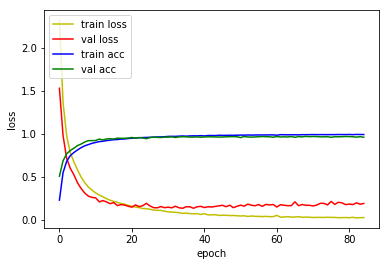

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.2077 - acc: 0.9431
Loss: 0.20771321481865515 Accuracy: 0.9430945

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1391 - acc: 0.2933
Epoch 00001: val_loss improved from inf to 1.24275, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_025_DO_9_conv_checkpoint/001-1.2427.hdf5
36805/36805 [==============================] - 109s 3ms/sample - loss: 2.1391 - acc: 0.2933 - val_loss: 1.2427 - val_acc: 0.5928
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0487 - acc: 0.6522
Epoch 00002: val_loss improved from 1.24275 to 0.79069, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_025_DO_9_conv_checkpoint/002-0.7907.hdf5
36805/36805 [==============================] - 92s 3ms/sample - loss: 1.0488 - acc: 0.6522 - val_loss: 0.7907 - val_acc: 0.7403
Epoch 3/500
36800/36805 [============================>.

36800/36805 [============================>.] - ETA: 0s - loss: 0.0715 - acc: 0.9755
Epoch 00025: val_loss did not improve from 0.16610
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0715 - acc: 0.9755 - val_loss: 0.2088 - val_acc: 0.9546
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0704 - acc: 0.9761
Epoch 00026: val_loss did not improve from 0.16610
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0704 - acc: 0.9761 - val_loss: 0.1805 - val_acc: 0.9550
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0668 - acc: 0.9777
Epoch 00027: val_loss did not improve from 0.16610
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0668 - acc: 0.9777 - val_loss: 0.1894 - val_acc: 0.9553
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0651 - acc: 0.9776
Epoch 00028: val_loss did not improve from 0.16610
36805/36805 [========================

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0246 - acc: 0.9918
Epoch 00055: val_loss did not improve from 0.16610
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0245 - acc: 0.9918 - val_loss: 0.2163 - val_acc: 0.9581
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0244 - acc: 0.9921
Epoch 00056: val_loss did not improve from 0.16610
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0244 - acc: 0.9921 - val_loss: 0.2098 - val_acc: 0.9574
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0257 - acc: 0.9915
Epoch 00057: val_loss did not improve from 0.16610
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0257 - acc: 0.9916 - val_loss: 0.2147 - val_acc: 0.9588
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0235 - acc: 0.9920
Epoch 00058: val_loss did not improve from 0.16610
36805/36805 [===========

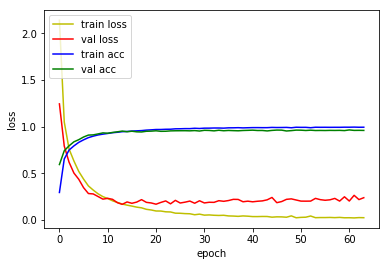

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.2646 - acc: 0.9202
Loss: 0.2645842428024189 Accuracy: 0.9202492



In [10]:
for i in range(1, 10):
    model_name = '1D_CNN_custom_conv_3_VGG_DO_025_DO_{}_conv'.format(i)
    model = build_1d_cnn_custom_conv_3_VGG_DO_025_DO(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)
    
    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_conv_3_VGG_DO_025_DO'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(1, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_conv_3_VGG_DO_025_DO_1_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_90 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
conv1d_91 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
flatten_9 (Flatten)          (None, 1024000)           0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024000)           0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                16384016  
Total params: 16,396,624
Trainable params: 16,396,624
Non-trainable params: 0
_________________________________________________________________
4815/4815 [==============================] - 3s 576us/sample - loss: 1.9995 - acc

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.8740 - acc: 0.7358
Loss: 0.8739624065897299 Accuracy: 0.73582554

1D_CNN_custom_conv_3_VGG_DO_025_DO_6_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_120 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
conv1d_121 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_122 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_123 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
max_pooling1d_46 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_124 (Conv1D)      

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.2077 - acc: 0.9431
Loss: 0.20771321481865515 Accuracy: 0.9430945

1D_CNN_custom_conv_3_VGG_DO_025_DO_9_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_162 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
conv1d_163 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_164 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_165 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
max_pooling1d_64 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_166 (Conv1D)      

In [12]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_conv_3_VGG_DO_025_DO'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(3, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_conv_3_VGG_DO_025_DO_3_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_96 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
conv1d_97 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_98 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_99 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
max_pooling1d_37 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_100 (Conv1D)          (None, 5333, 64)          12352     
_________________________________________________________________
conv1d_101 (Conv1D)        

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.6960 - acc: 0.8820
Loss: 0.6959577041963426 Accuracy: 0.8820353

1D_CNN_custom_conv_3_VGG_DO_025_DO_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_132 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
conv1d_133 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_134 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_135 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
max_pooling1d_51 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_136 (Conv1D)       

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.3177 - acc: 0.9373
Loss: 0.31773728911912646 Accuracy: 0.93727934
